<a href="https://colab.research.google.com/github/kundajelab/tfmodisco/blob/master/examples/simulated_TAL_GATA_deeplearning/TF_MoDISco_TAL_GATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF-MoDISco on the TAL GATA simulation

### Note: we are still refining the multi-task version of TF-MoDISco. If you encounter difficulties running TF-MoDISco with multiple tasks, our recommendation is to run it on one task at a time.

This notebook demonstrates running TF-MoDISco on importance scores obtained from the TAL-GATA simulation used in the DeepLIFT paper. See Generate Importance Scores.ipynb for a notebook demonstrating how to produce the scores. There are 3 tasks. Task 0 is positive when both TAL and GATA motifs are present in the sequence. Task 1 is positive when GATA motifs are present in the sequence. Task 2 is positive when TAL motifs are present in the sequence.

In [1]:
!pip install modisco

In [3]:
from __future__ import print_function, division
%matplotlib inline
/
try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [4]:
import numpy as np
import modisco
import sys
import os

## Grab the input data

In [4]:
#grab scores for tfmodisco
#!/usr/bin/env bash
![[ -f scores.h5 ]] || curl -o scores.h5 https://raw.githubusercontent.com/AvantiShri/model_storage/23d8f3ffc89af210f6f0bf7e65585eff259ba672/modisco/scores.h5
![[ -f sequences.simdata.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
![[ -f test.txt.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

## Functions for one-hot encoding sequences¶

In [5]:
#Functions for one-hot encoding sequences
import gzip

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [6]:
import h5py
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
n = 100 #since this is just a test run, for speed I am limiting to 100 sequences
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x)[::rc,::rc] for x in
                            f['contrib_scores'][task][:n] for rc in [1]]
    task_to_hyp_scores[task] = [np.array(x)[::rc, ::rc] for x in
                                f['hyp_contrib_scores'][task][:n] for rc in [1]]

onehot_data = [one_hot_encode_along_channel_axis(seq)[::rc, ::rc]
               for seq in fasta_sequences[:n]
               for rc in [1]]

Double check by plotting

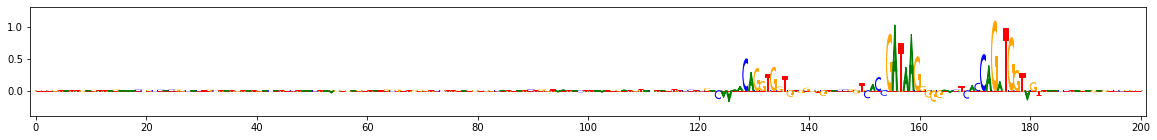

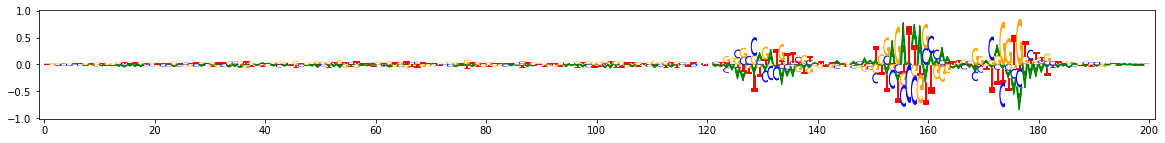

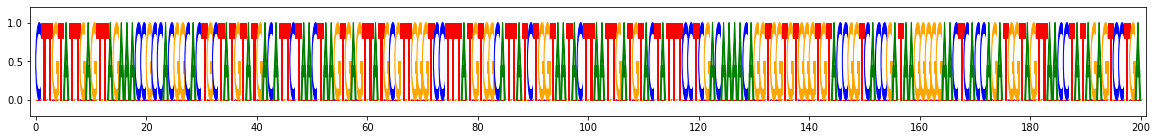

In [7]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=20)

Run TF-MoDISco
TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. Since there are 3 tasks, there are 27 possible metaclusters (consisting of a +1, -1 or 0 for each task). Consistent with the simulation, the [+1, +1, 0], [+1, 0, +1], [0, 0, +1] and [0, +1, 0] metaclusters turn up motifs.

To demonstrate customization, the code below has slight modifications from default settings in the following ways:

- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central trim_to_window_size bp with the highest importance. trim_to_window_size is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by initial_flank_to_add. This is set to 3 rather than the default of 10.
- The final_min_cluster_size is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 60 seqlets).
- It uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, which tends to run out of memory on many systems (I would change the default but want to avoid breaking reproducibility for older users)
- target_seqlet_fdr controls the noisiness of the seqlets. For a particular task, "significant" seqlets are identified by first smoothing importance scores with a window of size sliding_window_size and then fitting a laplace distribution to the left and right tails. This laplace distribution is assumed to represent the null distribution of window importance scores (note: as an alternative, it's possible to supply an empirical null distribution; see examples/H1ESC_Nanog_gkmsvm/TF MoDISco Nanog.ipynb for an example). A threshold is then identified such that the false discovery rate (computed as the ratio of the expected fraction of windows with a certain score in the null distribution relative to the observed fraction of windows with that score) is less that target_seqlet_fdr. Note: if the number of sliding windows that pass the FDR threshold is smaller than min_passing_windows_frac (default value 0.03 at the time of writing) or larger than max_passing_windows_frac (default value of 0.2 at the time of writing), the threshold will be adjusted.

MEMORY 0.130899968
On task task0
Fitting - on window size 5
peak(mu)= 0.00486588878557086
Computing window sums
Done computing window sums
For increasing = True , the minimum IR precision was 0.2954850349262155 occurring at 5.7220458984375e-06 implying a frac_neg of 0.41941626448668695
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.35928651361524633 occurring at -5.638343282043934e-06 implying a frac_neg of 0.5607600296390388
To be conservative, adjusted frac neg is 0.95


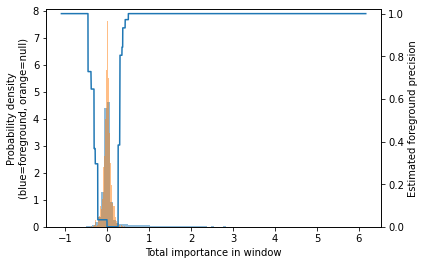

Fitting - on window size 9
peak(mu)= 0.0019212778508663174
Computing window sums
Done computing window sums
For increasing = True , the minimum IR precision was 0.31974367348777494 occurring at 6.765127182006836e-06 implying a frac_neg of 0.47003410483096586
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.4258213778275138 occurring at -2.9428978450596333e-05 implying a frac_neg of 0.7416183072374903
To be conservative, adjusted frac neg is 0.95


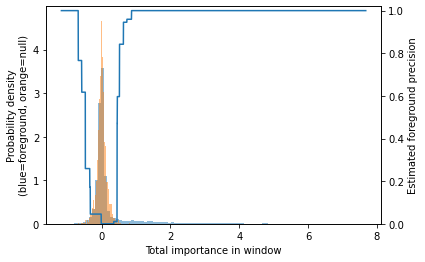

Fitting - on window size 13
peak(mu)= 0.014580504179000855
Computing window sums
Done computing window sums
For increasing = True , the minimum IR precision was 0.3469747405521833 occurring at 1.621246337890625e-05 implying a frac_neg of 0.5313343328335832
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.11749949829420027 occurring at -1.7642974853515625e-05 implying a frac_neg of 0.13314383172256963
To be conservative, adjusted frac neg is 0.95


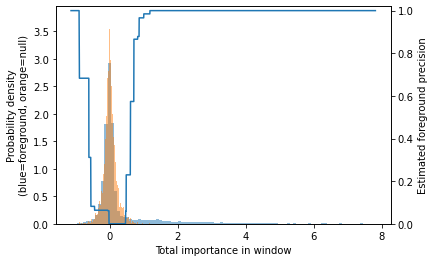

Fitting - on window size 17
peak(mu)= -0.03528579294681549
Computing window sums
Done computing window sums
For increasing = True , the minimum IR precision was 0.4006572406407763 occurring at 7.033348083496094e-06 implying a frac_neg of 0.6684943371454617
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.41327328308403144 occurring at -4.0531158447265625e-06 implying a frac_neg of 0.7043709978920574
To be conservative, adjusted frac neg is 0.95


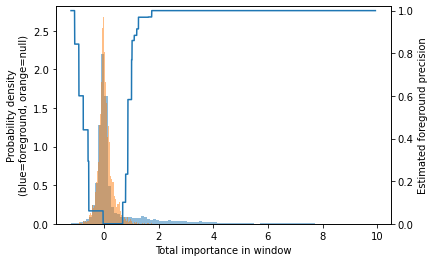

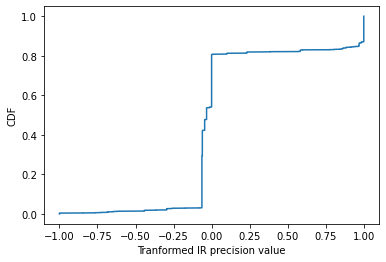

Thresholds from null dist were -0.85  and  0.85 with frac passing 0.17035
Got 318 coords
After resolving overlaps, got 318 seqlets
Across all tasks, the weakest transformed threshold used was: 0.8499
MEMORY 0.158728192
318 identified in total
1 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [298]
Idx to activities:  {0: '1'}
MEMORY 0.158765056
On metacluster 0
Metacluster size 298
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 298
(Round 1) Computing coarse affmat
MEMORY 0.15878144
Beginning embedding computation


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done 250 tasks      | elapsed:    4.2s
[Parallel(n_jobs=10)]: Done 279 out of 298 | elapsed:    4.6s remaining:    0.3s
[Parallel(n_jobs=10)]: Done 298 out of 298 | elapsed:    4.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 298 out of 298 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Constructing csr matrix...
csr matrix made in 0.06719017028808594 s
Constructing csr matrix...
csr matrix made in 0.06815409660339355 s
Finished embedding computation in 10.03 s
Starting affinity matrix computations
Batching in slices of size 500


[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:    0.7s finished
100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

Batching in slices of size 500



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

Finished affinity matrix computations in 1.73 s
(Round 1) Compute nearest neighbors from coarse affmat
MEMORY 0.2899968
Computed nearest neighbors in 0.02 s
MEMORY 0.2899968
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 0.2899968
Launching nearest neighbors affmat calculation job
MEMORY 0.292048896


Parallel runs completed
MEMORY 0.309334016
Job completed in: 1.19 s
MEMORY 0.309338112
Launching nearest neighbors affmat calculation job
MEMORY 0.309338112
Parallel runs completed
MEMORY 0.315056128
Job completed in: 1.21 s
MEMORY 0.315056128
(Round 1) Computed affinity matrix on nearest neighbors in 2.47 s
MEMORY 0.315056128
Filtered down to 291 of 298
(Round 1) Retained 291 rows out of 298 after filtering
MEMORY 0.315256832
(Round 1) Computing density adapted affmat
MEMORY 0.315256832
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 291 samples in 0.001s...
[t-SNE] Computed neighbors for 291 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 291 / 291
[t-SNE] Mean sigma: 0.232271
(Round 1) Computing clustering
MEMORY 0.315293696
Beginning preprocessing + Leiden


  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.6632175729969298
Quality: 0.6635930382169241


  6%|▌         | 3/50 [00:00<00:01, 23.65it/s]

Quality: 0.6638219820788932


100%|██████████| 50/50 [00:01<00:00, 27.73it/s]

Got 5 clusters after round 1
Counts:
{4: 17, 0: 79, 2: 67, 1: 79, 3: 49}
MEMORY 0.31578112
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.31578112
Aggregating for cluster 0 with 79 seqlets
MEMORY 0.31578112


Trimming eliminated 0 seqlets out of 79
Skipped 16 seqlets
Aggregating for cluster 1 with 79 seqlets
MEMORY 0.31578112
Trimming eliminated 0 seqlets out of 79
Skipped 7 seqlets
Aggregating for cluster 2 with 67 seqlets
MEMORY 0.315789312
Trimming eliminated 0 seqlets out of 67
Skipped 8 seqlets
Removed 1 duplicate seqlets
Aggregating for cluster 3 with 49 seqlets
MEMORY 0.315789312
Trimming eliminated 0 seqlets out of 49
Skipped 3 seqlets
Removed 1 duplicate seqlets
Aggregating for cluster 4 with 17 seqlets
MEMORY 0.315789312
Trimming eliminated 0 seqlets out of 17
Skipped 1 seqlets
(Round 2) num seqlets: 223
(Round 2) Computing coarse affmat
MEMORY 0.315789312
Beginning embedding computation


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 204 out of 223 | elapsed:    4.4s remaining:    0.4s
[Parallel(n_jobs=10)]: Done 223 out of 223 | elapsed:    4.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 204 out of 223 | elapsed:    4.0s remaining:    0.4s
[Parallel(n_jobs=10)]: Done 223 out of 223 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 223 out of 223 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Constructing csr matrix...
csr matrix made in 0.05225801467895508 s
Constructing csr matrix...
csr matrix made in 0.04984688758850098 s
Finished embedding computation in 10.23 s
Starting affinity matrix computations
Batching in slices of size 500


[Parallel(n_jobs=1)]: Done 223 out of 223 | elapsed:    0.6s finished
100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

Batching in slices of size 500



100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

Finished affinity matrix computations in 1.74 s
(Round 2) Compute nearest neighbors from coarse affmat
MEMORY 0.319156224
Computed nearest neighbors in 0.02 s
MEMORY 0.319156224
(Round 2) Computing affinity matrix on nearest neighbors
MEMORY 0.319156224
Launching nearest neighbors affmat calculation job
MEMORY 0.319156224


Parallel runs completed
MEMORY 0.31922176
Job completed in: 0.72 s
MEMORY 0.31922176
Launching nearest neighbors affmat calculation job
MEMORY 0.31922176
Parallel runs completed
MEMORY 0.319250432
Job completed in: 0.63 s
MEMORY 0.319250432
(Round 2) Computed affinity matrix on nearest neighbors in 1.41 s
MEMORY 0.319250432
Not applying filtering for rounds above first round
MEMORY 0.319250432
(Round 2) Computing density adapted affmat
MEMORY 0.319250432
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 223 samples in 0.000s...
[t-SNE] Computed neighbors for 223 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 223 / 223
[t-SNE] Mean sigma: 0.279836
(Round 2) Computing clustering
MEMORY 0.319250432
Beginning preprocessing + Leiden


  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.599614126588206
Quality: 0.5999271629421645


100%|██████████| 50/50 [00:01<00:00, 27.62it/s]

Got 10 clusters after round 2
Counts:
{2: 27, 1: 28, 4: 26, 6: 9, 3: 27, 5: 17, 9: 2, 7: 5, 0: 79, 8: 3}
MEMORY 0.31950848
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.31950848
Aggregating for cluster 0 with 79 seqlets
MEMORY 0.31950848


Trimming eliminated 0 seqlets out of 79
Aggregating for cluster 1 with 28 seqlets
MEMORY 0.31950848
Trimming eliminated 0 seqlets out of 28
Removed 7 duplicate seqlets
Aggregating for cluster 2 with 27 seqlets
MEMORY 0.31950848
Trimming eliminated 0 seqlets out of 27
Removed 8 duplicate seqlets
Aggregating for cluster 3 with 27 seqlets
MEMORY 0.31950848
Trimming eliminated 0 seqlets out of 27
Removed 10 duplicate seqlets
Aggregating for cluster 4 with 26 seqlets
MEMORY 0.31950848
Trimming eliminated 0 seqlets out of 26
Removed 11 duplicate seqlets
Aggregating for cluster 5 with 17 seqlets
MEMORY 0.31950848
Trimming eliminated 0 seqlets out of 17
Removed 6 duplicate seqlets
Aggregating for cluster 6 with 9 seqlets
MEMORY 0.31950848
Trimming eliminated 0 seqlets out of 9
Removed 4 duplicate seqlets
Aggregating for cluster 7 with 5 seqlets
MEMORY 0.31950848
Trimming eliminated 0 seqlets out of 5
Removed 1 duplicate seqlets
Aggregating for cluster 8 with 3 seqlets
MEMORY 0.31950848
Trimmin

In [5]:
import h5py
import numpy as np
%matplotlib inline
import modisco

reload(modisco.coordproducers)
reload(modisco.seqlet_embedding.advanced_gapped_kmer)
reload(modisco.seqlet_embedding)

null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=[5,9,13,17],
                    flank_size=5,
                    target_seqlet_fdr=0.15,
    
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        #Note: as of version 0.5.6.0, it's possible to use the results of a motif discovery
                        # software like MEME to improve the TF-MoDISco clustering. To use the meme-based
                        # initialization, you would specify the initclusterer_factory as shown in the
                        # commented-out code below:
                        #initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
                        #    meme_command="meme", base_outdir="meme_out",            
                        #    max_num_seqlets_to_use=10000, nmotifs=10, n_jobs=1),
                        
                        embedder_factory=(modisco.seqlet_embedding
                          .advanced_gapped_kmer.AdvancedGappedKmerEmbedderFactory(max_entries=500)),
                        
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        #kmer_len=5, num_gaps=1,
                        #num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                 task_names=["task0"],# "task1", "task2"],
                 contrib_scores=task_to_scores,
                 hypothetical_contribs=task_to_hyp_scores,
                 one_hot=onehot_data,
                 null_per_pos_scores = null_per_pos_scores)

## Save Results

In [6]:
import h5py
import modisco.util
reload(modisco.util)
![[ -e results.hdf5 ]] && rm results.hdf5
grp = h5py.File("results.hdf5", "w")
tfmodisco_results.save_hdf5(grp)
grp.close()

## Print results directly from hdf5

Metaclusters heatmap


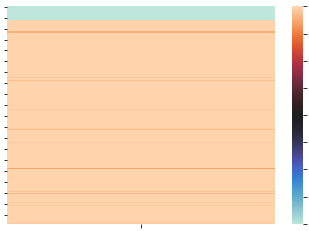

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 83
Task 0 hypothetical scores:


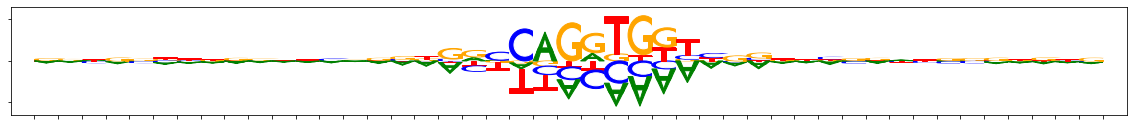

Task 0 actual importance scores:


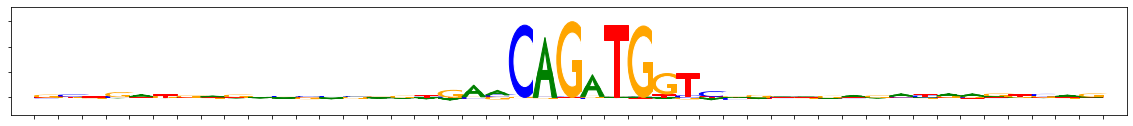

onehot, fwd and rev:


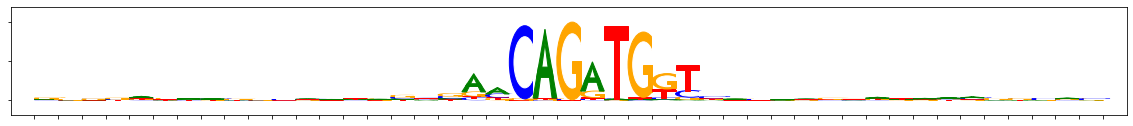

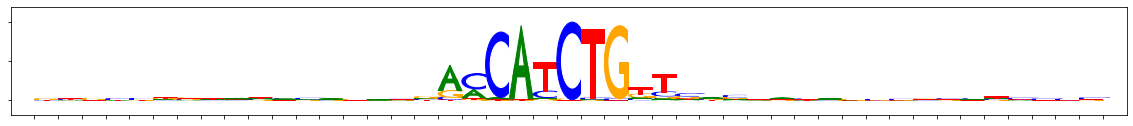

metacluster_0 pattern_1
total seqlets: 81
Task 0 hypothetical scores:


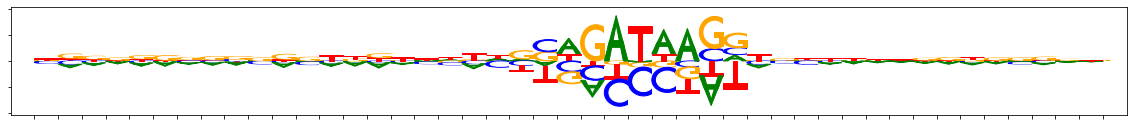

Task 0 actual importance scores:


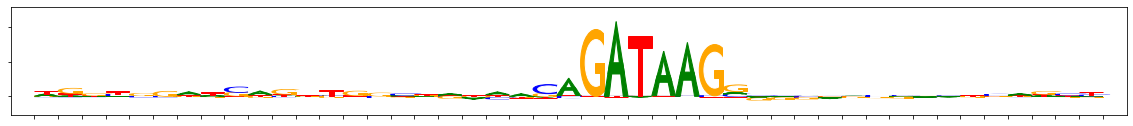

onehot, fwd and rev:


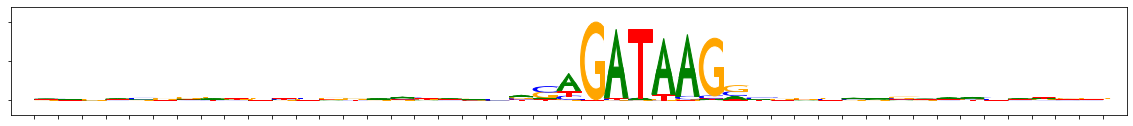

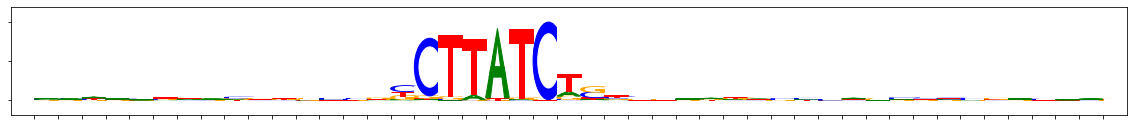

In [7]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []
background = np.array([0.27, 0.23, 0.23, 0.27])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        #print("Task 1 hypothetical scores:")
        #viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        #print("Task 1 actual importance scores:")
        #viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        #print("Task 2 hypothetical scores:")
        #viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        #print("Task 2 actual importance scores:")
        #viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()

## Load the saved hdf5 file
Load the results object from the saved file

In [7]:
import h5py
import numpy as np
import modisco
from modisco.tfmodisco_workflow import workflow

from importlib import reload

reload(modisco.tfmodisco_workflow.workflow)
reload(modisco.tfmodisco_workflow)
reload(modisco)
reload(modisco.core)
reload(modisco)

track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=tasks,
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

grp = h5py.File("results.hdf5","r")
loaded_tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

Loaded sliding window sizes: [ 5  9 13 17]
For increasing = True , the minimum IR precision was 0.2954850349262155 occurring at 5.7220458984375e-06 implying a frac_neg of 0.41941626448668695
To be conservative, adjusted frac neg is 0.95
For increasing = True , the minimum IR precision was 0.31974367348777494 occurring at 6.765127182006836e-06 implying a frac_neg of 0.47003410483096586
To be conservative, adjusted frac neg is 0.95
For increasing = True , the minimum IR precision was 0.3469747405521833 occurring at 1.621246337890625e-05 implying a frac_neg of 0.5313343328335832
To be conservative, adjusted frac neg is 0.95
For increasing = True , the minimum IR precision was 0.4006572406407763 occurring at 7.033348083496094e-06 implying a frac_neg of 0.6684943371454617
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.35928651361524633 occurring at -5.638343282043934e-06 implying a frac_neg of 0.5607600296390388
To be conservative, adju

Getting the exemplar motifs
Numseqles: 83


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  83 out of  83 | elapsed:    1.8s finished


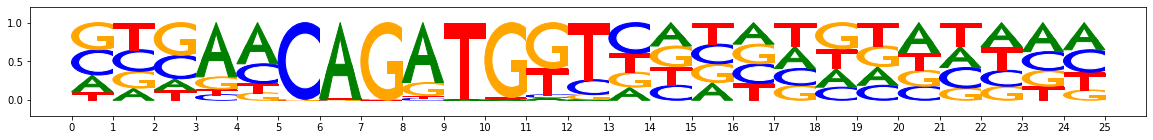

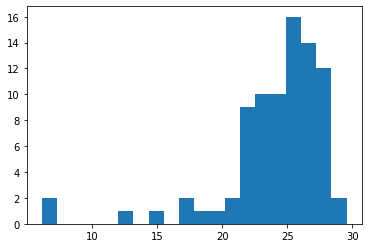

After filtering: numseqlets 79


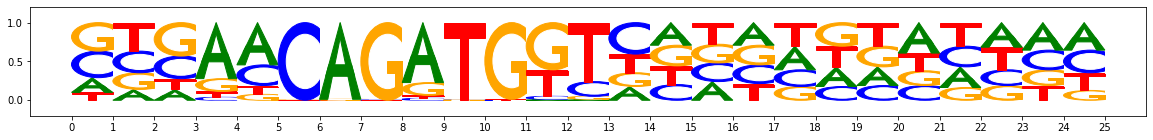

Numseqles: 81


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  81 out of  81 | elapsed:    0.1s finished


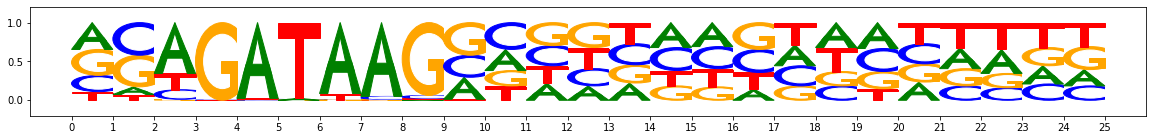

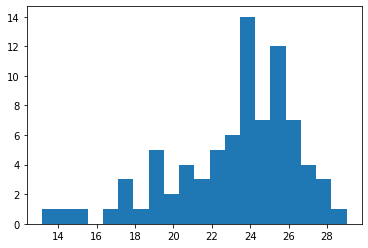

After filtering: numseqlets 80


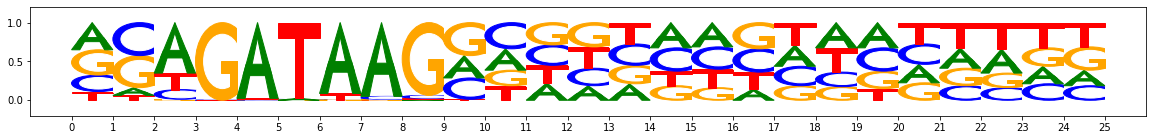

Getting labels
Getting impscores data
Computing fwd sims


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 4090 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 4754 out of 4754 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    0.1s finished


Took 0.25251197814941406 s
Getting impscores data
Computing fwd sims


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 4090 tasks      | elapsed:    0.2s


Took 0.24987316131591797 s


[Parallel(n_jobs=10)]: Done 4754 out of 4754 | elapsed:    0.2s finished


In [9]:
from modisco.hit_scoring import exemplar_based_hitscoring
reload(exemplar_based_hitscoring)

SCANNING_WINDOW_WIDTH=25

instance_scorer = exemplar_based_hitscoring.prepare_instance_scorer(
    patterns=(loaded_tfmodisco_results
                .metacluster_idx_to_submetacluster_results["metacluster_0"]
                .seqlets_to_patterns_result.patterns),
    trim_window_size=SCANNING_WINDOW_WIDTH,
    task_names=tasks, bg_freq=np.array([0.27, 0.23, 0.23, 0.27]), track_set=track_set)

In [17]:
from collections import defaultdict
from modisco.hit_scoring import exemplar_based_hitscoring
reload(exemplar_based_hitscoring)

CUTOFF_VALUE = 0.8
coordinates_to_be_scanned, task0_transformed_scoretrack =\
    exemplar_based_hitscoring.get_windows_to_be_scanned(
        scanning_window_width=SCANNING_WINDOW_WIDTH,
        contrib_scores=task_to_scores["task0"],
        val_transformer=(loaded_tfmodisco_results.
            multitask_seqlet_creation_results.
            task_name_to_tnt_results["task0"].val_transformer),
        cutoff_value=CUTOFF_VALUE)
        

computing the transformed score track
done computing the transformed score track
Fraction of values above cutoff: 0.16915


In [18]:
reload(exemplar_based_hitscoring)

(motifmatch_to_coordinates,
 motifmatch_to_coordinatesbyregionidx,
 motif_scores, motif_precisions,
 besthit_isrevcomp) = (
 exemplar_based_hitscoring.scan_and_process_results(
    instance_scorer=instance_scorer, track_set=track_set,
    coordinates=coordinates_to_be_scanned))

Getting impscores data
Computing fwd sims


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 9780 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 13870 out of 13870 | elapsed:    0.5s finished


Took 0.5251750946044922 s


Index 0


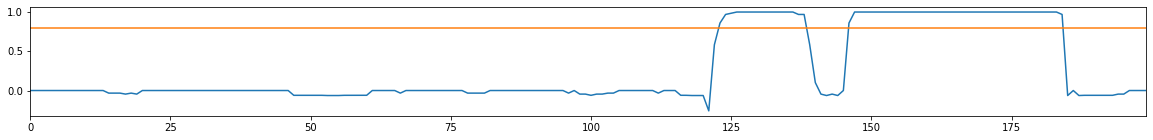

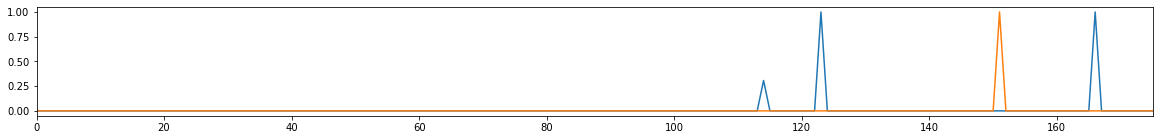

tal hits:
MotifHitAndCoord(motif_idx=0, motif_score=0.6285057524184436, precision_at_motif_score=0.3070218532110743, example_idx=0, start=114, end=139, is_revcomp=True)
MotifHitAndCoord(motif_idx=0, motif_score=0.99176677132715, precision_at_motif_score=1.0, example_idx=0, start=123, end=148, is_revcomp=False)
MotifHitAndCoord(motif_idx=0, motif_score=0.5289917008354178, precision_at_motif_score=0.0, example_idx=0, start=157, end=182, is_revcomp=True)
MotifHitAndCoord(motif_idx=0, motif_score=0.9904893311402659, precision_at_motif_score=1.0, example_idx=0, start=166, end=191, is_revcomp=False)
gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.9979234390801821, precision_at_motif_score=1.0, example_idx=0, start=151, end=176, is_revcomp=False)


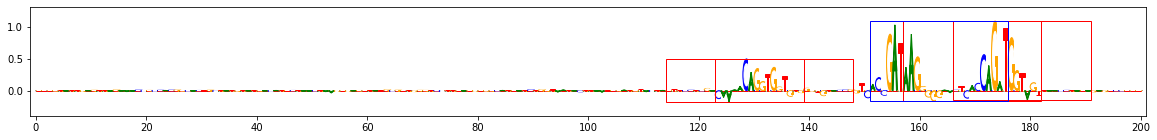

Index 1


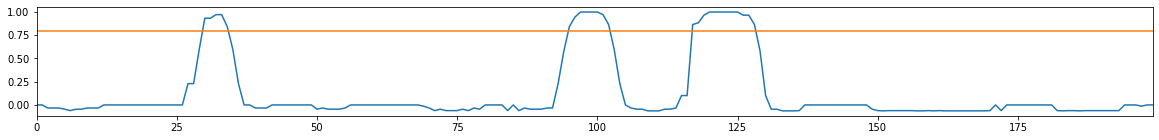

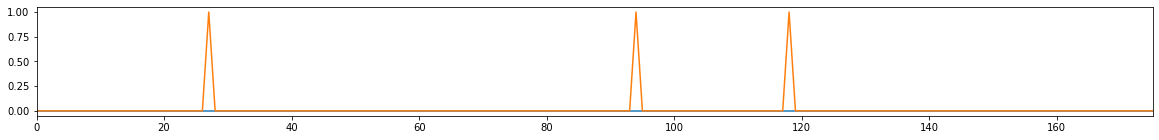

tal hits:

gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.9962569527702348, precision_at_motif_score=1.0, example_idx=1, start=27, end=52, is_revcomp=False)
MotifHitAndCoord(motif_idx=1, motif_score=0.9984996416657448, precision_at_motif_score=1.0, example_idx=1, start=94, end=119, is_revcomp=False)
MotifHitAndCoord(motif_idx=1, motif_score=0.999586211201367, precision_at_motif_score=1.0, example_idx=1, start=118, end=143, is_revcomp=False)


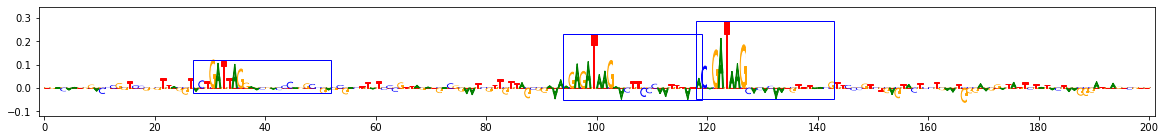

Index 2


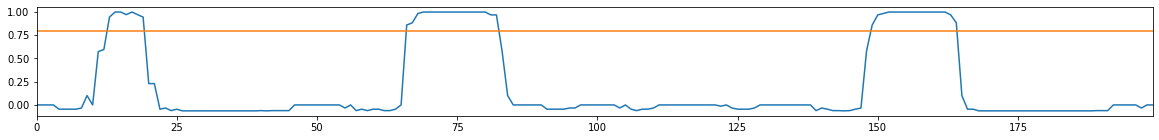

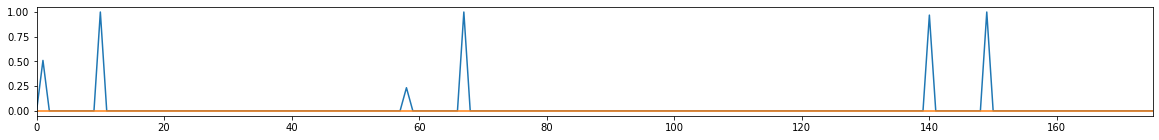

tal hits:
MotifHitAndCoord(motif_idx=0, motif_score=0.6944054987801238, precision_at_motif_score=0.5103364799622766, example_idx=2, start=1, end=26, is_revcomp=True)
MotifHitAndCoord(motif_idx=0, motif_score=0.9891952379569223, precision_at_motif_score=1.0, example_idx=2, start=10, end=35, is_revcomp=False)
MotifHitAndCoord(motif_idx=0, motif_score=0.6048776086118255, precision_at_motif_score=0.2341240424592603, example_idx=2, start=58, end=83, is_revcomp=True)
MotifHitAndCoord(motif_idx=0, motif_score=0.9985309195064332, precision_at_motif_score=1.0, example_idx=2, start=67, end=92, is_revcomp=False)
MotifHitAndCoord(motif_idx=0, motif_score=0.8430095831557372, precision_at_motif_score=0.9688114455973597, example_idx=2, start=140, end=165, is_revcomp=True)
MotifHitAndCoord(motif_idx=0, motif_score=0.9994820346600571, precision_at_motif_score=1.0, example_idx=2, start=149, end=174, is_revcomp=False)
gata hits:



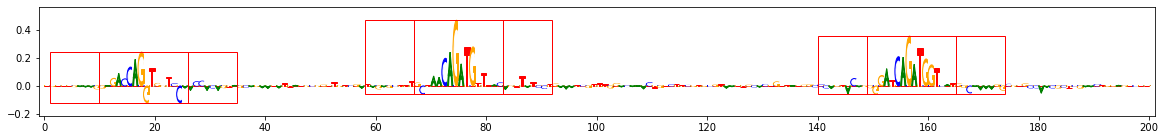

Index 3


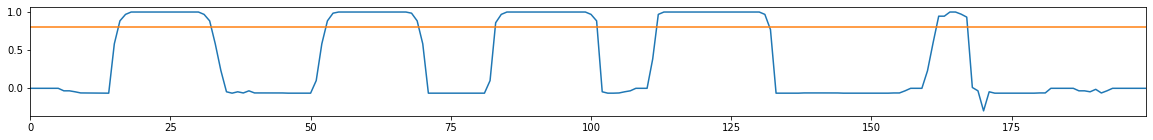

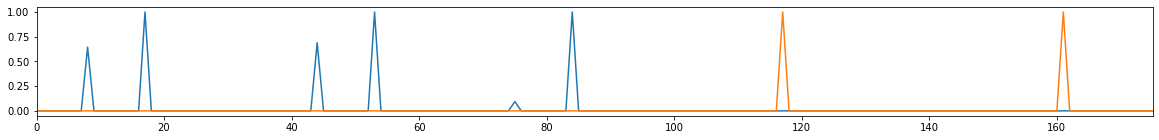

tal hits:
MotifHitAndCoord(motif_idx=0, motif_score=0.7378554041914969, precision_at_motif_score=0.6443886089735836, example_idx=3, start=8, end=33, is_revcomp=True)
MotifHitAndCoord(motif_idx=0, motif_score=0.9925613965072331, precision_at_motif_score=1.0, example_idx=3, start=17, end=42, is_revcomp=False)
MotifHitAndCoord(motif_idx=0, motif_score=0.7521851743143521, precision_at_motif_score=0.6885989743362789, example_idx=3, start=44, end=69, is_revcomp=True)
MotifHitAndCoord(motif_idx=0, motif_score=0.9989676488963165, precision_at_motif_score=1.0, example_idx=3, start=53, end=78, is_revcomp=False)
MotifHitAndCoord(motif_idx=0, motif_score=0.559340500323617, precision_at_motif_score=0.09363245203441768, example_idx=3, start=75, end=100, is_revcomp=True)
MotifHitAndCoord(motif_idx=0, motif_score=0.9973942484679885, precision_at_motif_score=1.0, example_idx=3, start=84, end=109, is_revcomp=False)
gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.9998660881398925, precision_at_mot

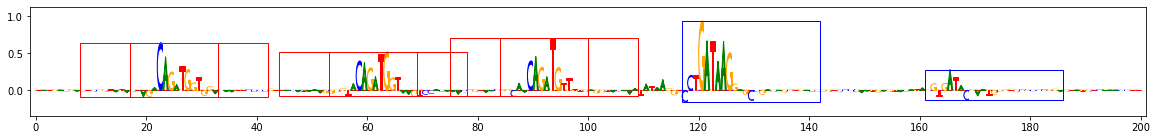

Index 4


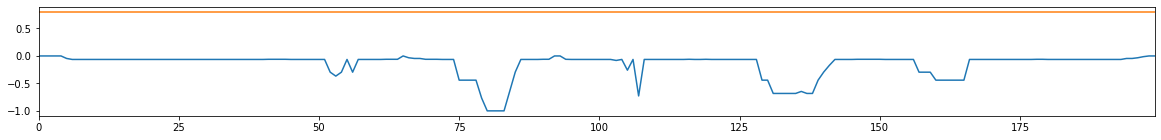

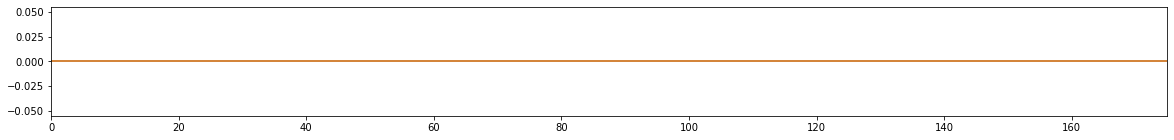

tal hits:

gata hits:



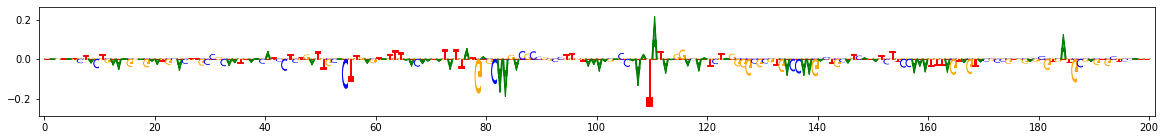

Index 5


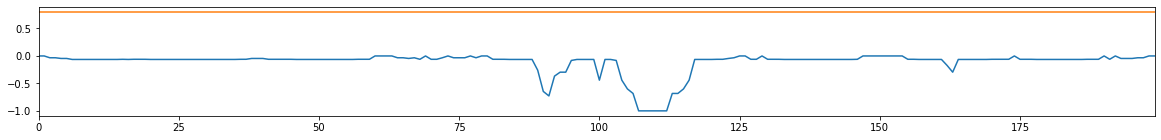

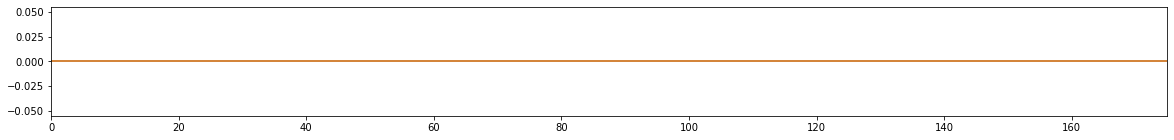

tal hits:

gata hits:



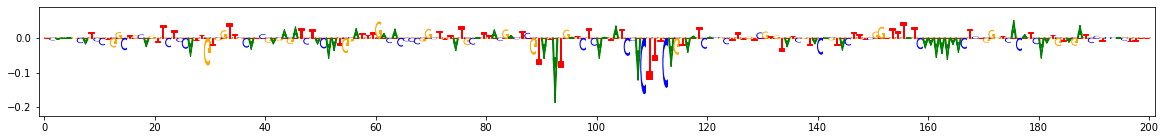

Index 6


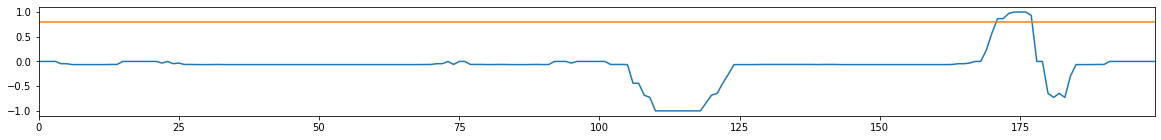

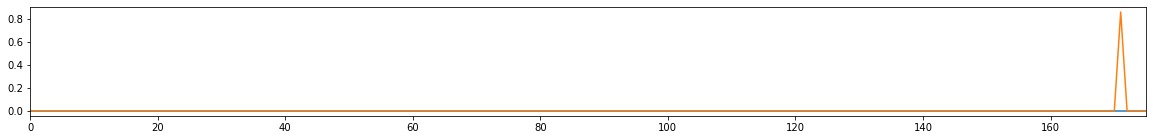

tal hits:

gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.8603651821491742, precision_at_motif_score=0.8641402146551365, example_idx=6, start=171, end=196, is_revcomp=False)


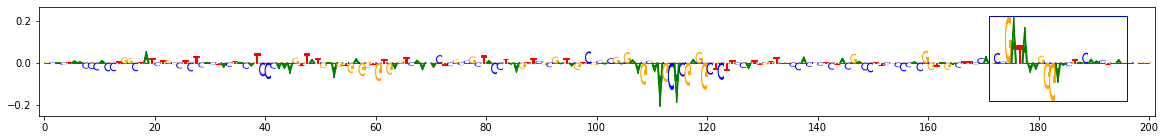

Index 7


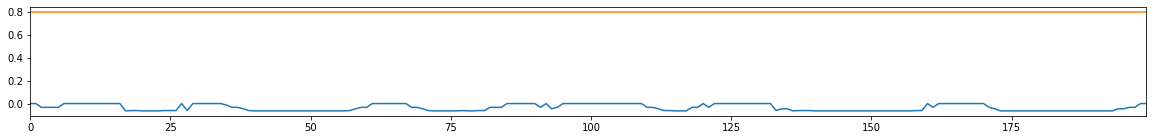

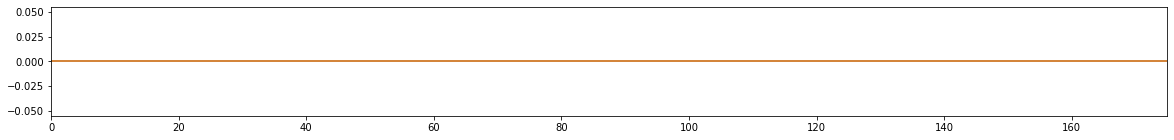

tal hits:

gata hits:



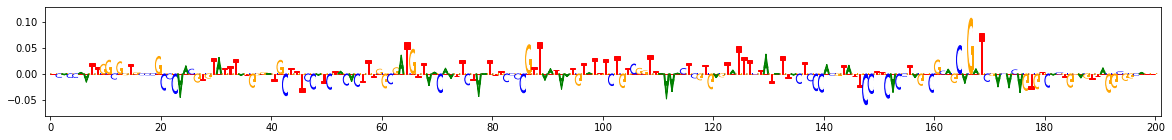

Index 8


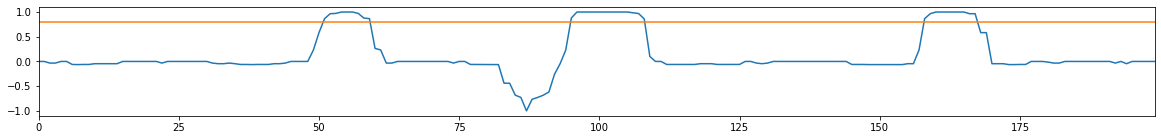

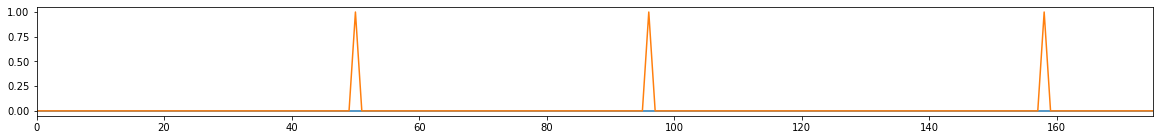

tal hits:

gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.9981404370073454, precision_at_motif_score=1.0, example_idx=8, start=50, end=75, is_revcomp=False)
MotifHitAndCoord(motif_idx=1, motif_score=0.9997666971054194, precision_at_motif_score=1.0, example_idx=8, start=96, end=121, is_revcomp=False)
MotifHitAndCoord(motif_idx=1, motif_score=0.999439902805966, precision_at_motif_score=1.0, example_idx=8, start=158, end=183, is_revcomp=False)


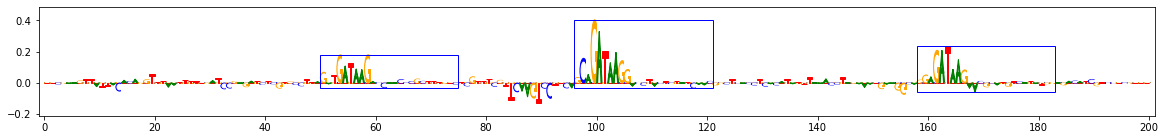

Index 9


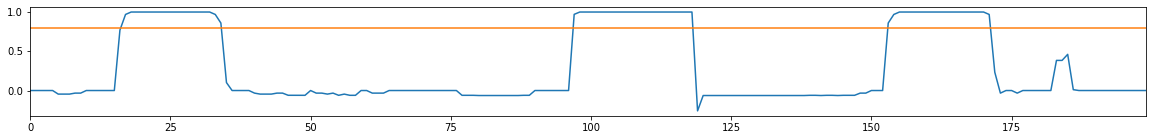

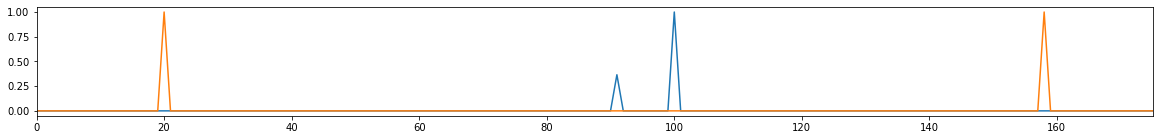

tal hits:
MotifHitAndCoord(motif_idx=0, motif_score=0.6473985105327982, precision_at_motif_score=0.36530999962121485, example_idx=9, start=91, end=116, is_revcomp=True)
MotifHitAndCoord(motif_idx=0, motif_score=0.9985691044998529, precision_at_motif_score=1.0, example_idx=9, start=100, end=125, is_revcomp=False)
gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.9970444216566418, precision_at_motif_score=1.0, example_idx=9, start=20, end=45, is_revcomp=False)
MotifHitAndCoord(motif_idx=1, motif_score=0.9977360701996126, precision_at_motif_score=1.0, example_idx=9, start=158, end=183, is_revcomp=False)


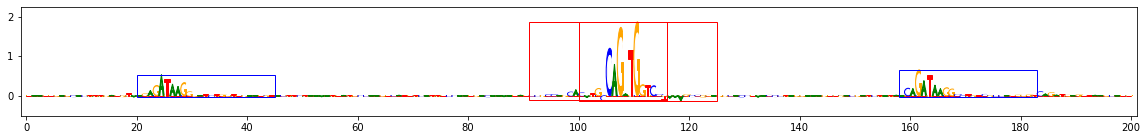

Index 10


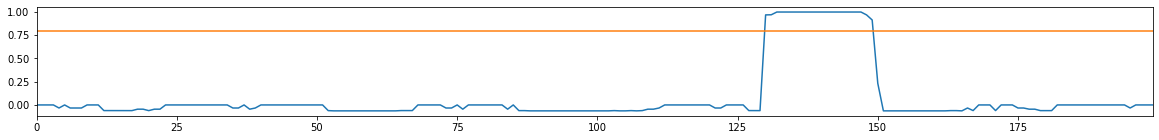

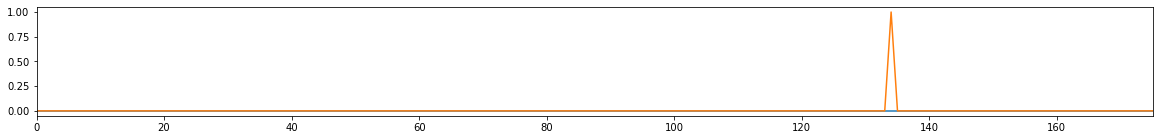

tal hits:

gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.9987752343034744, precision_at_motif_score=1.0, example_idx=10, start=134, end=159, is_revcomp=False)


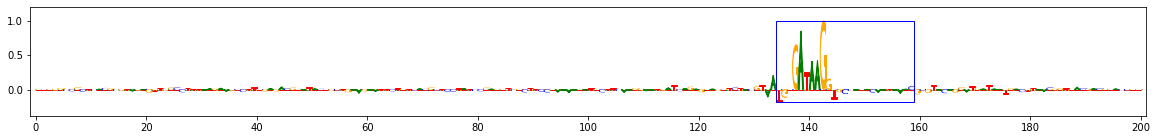

Index 11


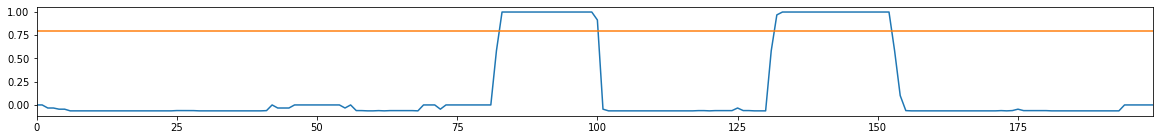

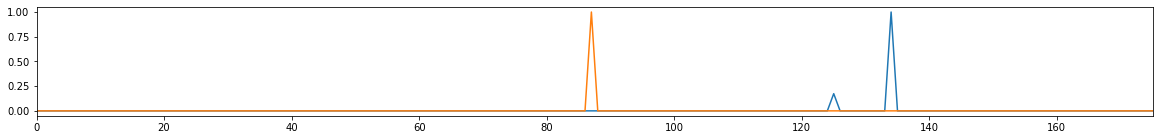

tal hits:
MotifHitAndCoord(motif_idx=0, motif_score=0.5853519199622497, precision_at_motif_score=0.17388317175756188, example_idx=11, start=125, end=150, is_revcomp=True)
MotifHitAndCoord(motif_idx=0, motif_score=0.9987065898945097, precision_at_motif_score=1.0, example_idx=11, start=134, end=159, is_revcomp=False)
gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.9971862166306695, precision_at_motif_score=1.0, example_idx=11, start=87, end=112, is_revcomp=False)


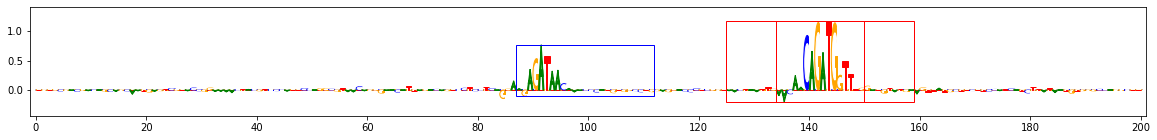

Index 12


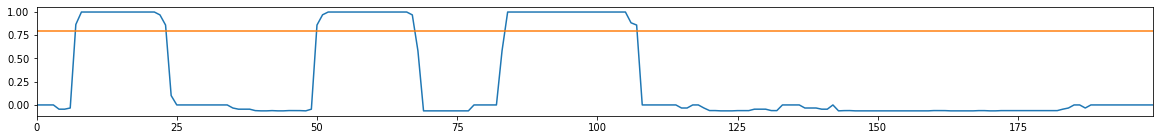

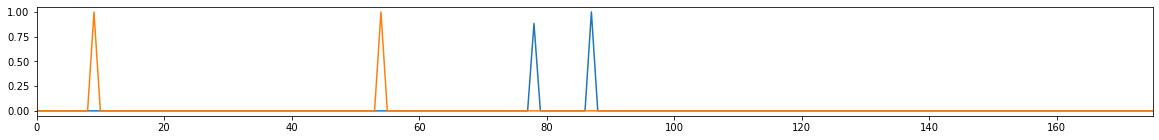

tal hits:
MotifHitAndCoord(motif_idx=0, motif_score=0.8154915419587708, precision_at_motif_score=0.8839124803694945, example_idx=12, start=78, end=103, is_revcomp=True)
MotifHitAndCoord(motif_idx=0, motif_score=0.9988626778306542, precision_at_motif_score=1.0, example_idx=12, start=87, end=112, is_revcomp=False)
gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.9991338656491993, precision_at_motif_score=1.0, example_idx=12, start=9, end=34, is_revcomp=False)
MotifHitAndCoord(motif_idx=1, motif_score=0.9987711343289296, precision_at_motif_score=1.0, example_idx=12, start=54, end=79, is_revcomp=False)


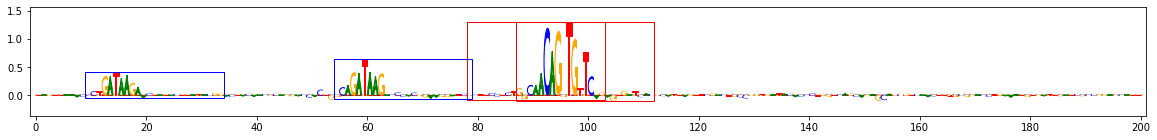

Index 13


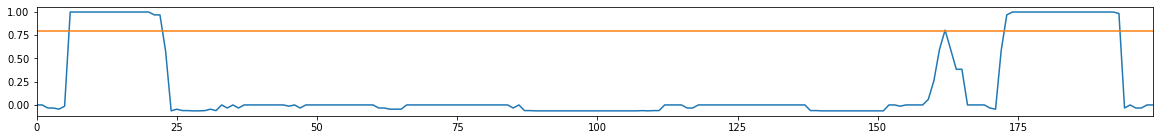

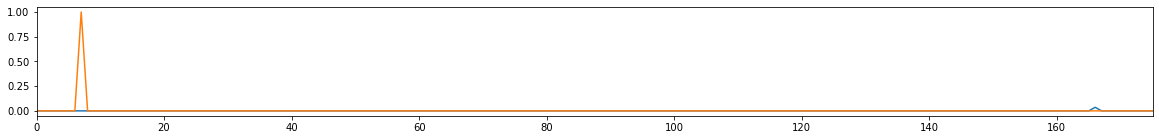

tal hits:
MotifHitAndCoord(motif_idx=0, motif_score=0.5406507678829533, precision_at_motif_score=0.0359706826795211, example_idx=13, start=166, end=191, is_revcomp=True)
gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.997247452387785, precision_at_motif_score=1.0, example_idx=13, start=7, end=32, is_revcomp=False)
MotifHitAndCoord(motif_idx=1, motif_score=0.5034202610363904, precision_at_motif_score=0.0, example_idx=13, start=156, end=181, is_revcomp=False)


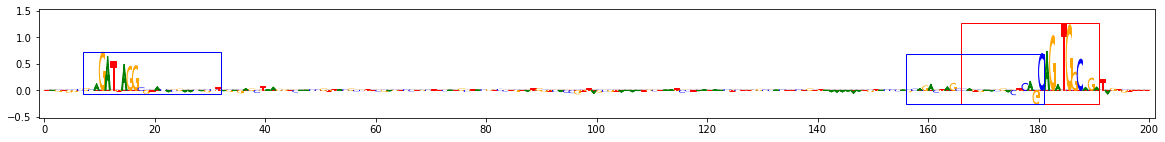

Index 14


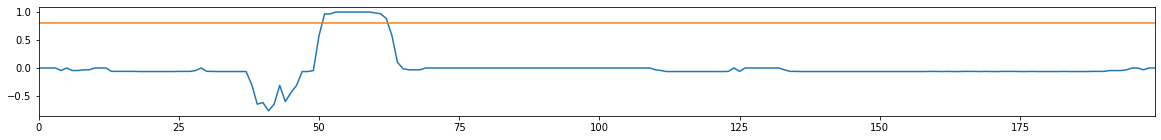

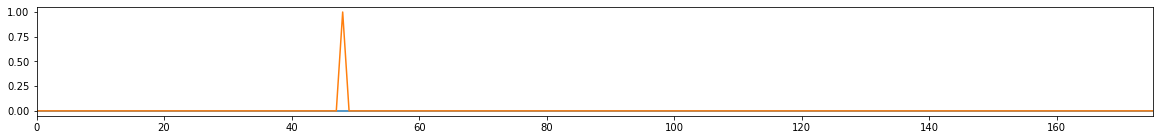

tal hits:

gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.9753179158689952, precision_at_motif_score=1.0, example_idx=14, start=48, end=73, is_revcomp=False)


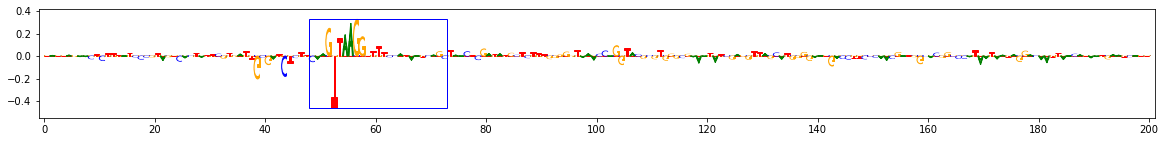

Index 15


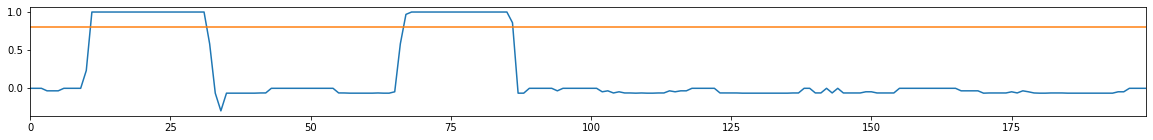

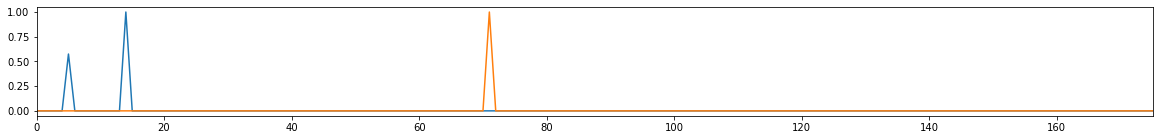

tal hits:
MotifHitAndCoord(motif_idx=0, motif_score=0.7153383485669246, precision_at_motif_score=0.5749187397768176, example_idx=15, start=5, end=30, is_revcomp=True)
MotifHitAndCoord(motif_idx=0, motif_score=0.9978017165798071, precision_at_motif_score=1.0, example_idx=15, start=14, end=39, is_revcomp=False)
gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.99879188230101, precision_at_motif_score=1.0, example_idx=15, start=71, end=96, is_revcomp=False)


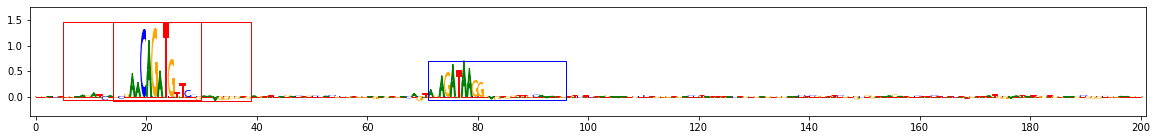

Index 16


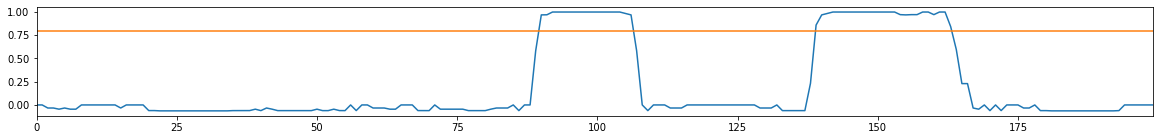

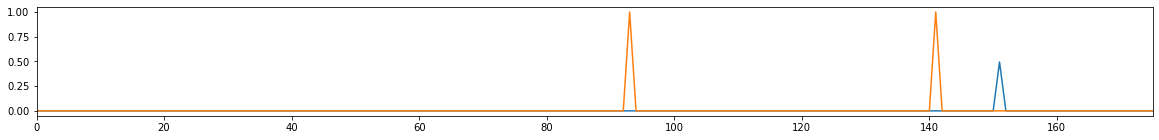

tal hits:
MotifHitAndCoord(motif_idx=0, motif_score=0.6892776788679775, precision_at_motif_score=0.49451607322256813, example_idx=16, start=151, end=176, is_revcomp=False)
gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.9986697361501782, precision_at_motif_score=1.0, example_idx=16, start=93, end=118, is_revcomp=False)
MotifHitAndCoord(motif_idx=1, motif_score=0.9935929306105755, precision_at_motif_score=1.0, example_idx=16, start=141, end=166, is_revcomp=False)


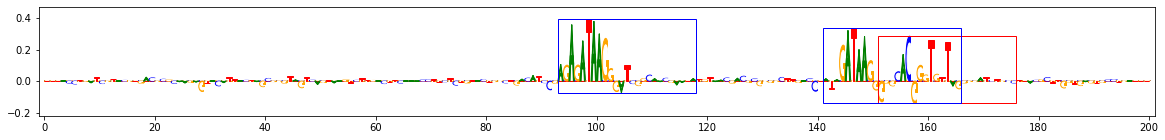

Index 17


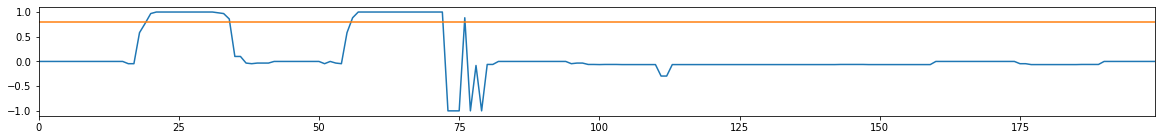

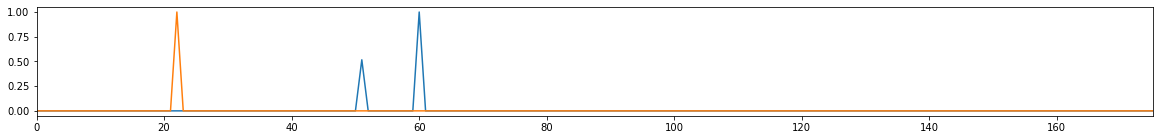

tal hits:
MotifHitAndCoord(motif_idx=0, motif_score=0.6964419108674892, precision_at_motif_score=0.5166192410700657, example_idx=17, start=51, end=76, is_revcomp=True)
MotifHitAndCoord(motif_idx=0, motif_score=0.9889639466665181, precision_at_motif_score=1.0, example_idx=17, start=60, end=85, is_revcomp=False)
gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.980346181222182, precision_at_motif_score=1.0, example_idx=17, start=22, end=47, is_revcomp=False)


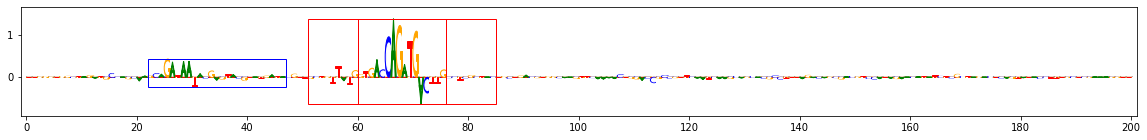

Index 18


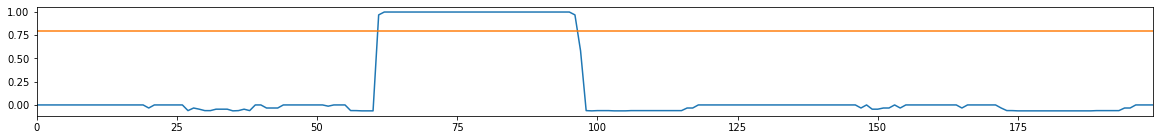

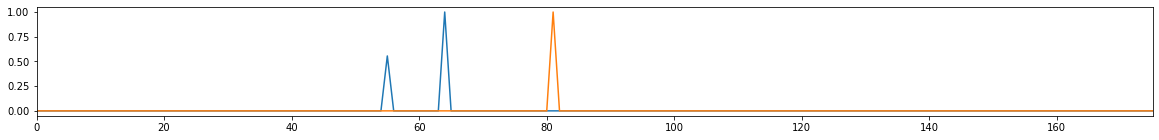

tal hits:
MotifHitAndCoord(motif_idx=0, motif_score=0.7090678572343863, precision_at_motif_score=0.5555729505256013, example_idx=18, start=55, end=80, is_revcomp=True)
MotifHitAndCoord(motif_idx=0, motif_score=0.9946302266035284, precision_at_motif_score=1.0, example_idx=18, start=64, end=89, is_revcomp=False)
gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.9988318641019158, precision_at_motif_score=1.0, example_idx=18, start=81, end=106, is_revcomp=False)


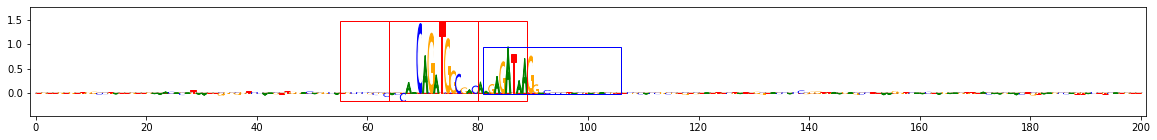

Index 19


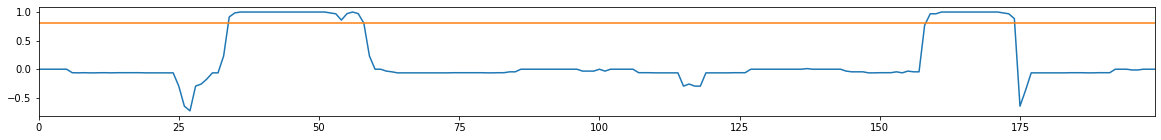

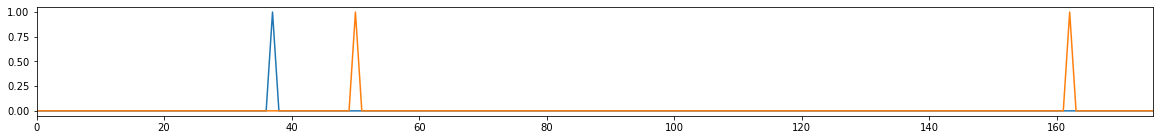

tal hits:
MotifHitAndCoord(motif_idx=0, motif_score=0.8531186336326444, precision_at_motif_score=1.0, example_idx=19, start=37, end=62, is_revcomp=False)
gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.9126089200188778, precision_at_motif_score=1.0, example_idx=19, start=50, end=75, is_revcomp=False)
MotifHitAndCoord(motif_idx=1, motif_score=0.9993329703323126, precision_at_motif_score=1.0, example_idx=19, start=162, end=187, is_revcomp=False)


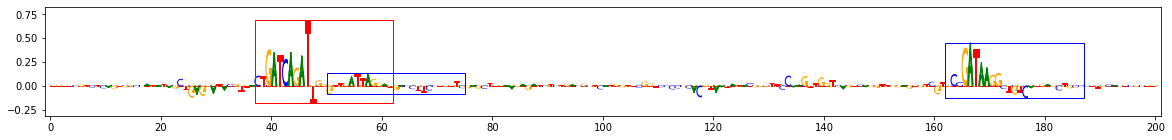

In [19]:
from modisco.visualization import viz_sequence
reload(modisco.visualization.viz_sequence)
reload(modisco.visualization)
from matplotlib import pyplot as plt

def visualize_idx(idx_to_viz):
    viz_sequence.plot_score_track(task0_transformed_scoretrack[idx_to_viz],
                                  threshold=CUTOFF_VALUE)
    
    fig = plt.figure(figsize=(20,2))
    ax = fig.add_subplot(111)
    viz_sequence.plot_score_track_given_ax(arr=motif_precisions[idx_to_viz][:,0], ax=ax) #tal score plot (start idx)
    viz_sequence.plot_score_track_given_ax(arr=motif_precisions[idx_to_viz][:,1], ax=ax) #gata score plot (start idx)
    plt.show()
    
    print("tal hits:\n"+"\n".join([str(x) for x in motifmatch_to_coordinatesbyregionidx[0][idx_to_viz]]))
    print("gata hits:\n"+"\n".join([str(x) for x in motifmatch_to_coordinatesbyregionidx[1][idx_to_viz]]))
    viz_sequence.plot_weights(task_to_scores["task0"][idx_to_viz],
                              highlight={
                                  'red': [(x.start, x.end) for x in
                                          motifmatch_to_coordinatesbyregionidx[0][idx_to_viz]],
                                  'blue': [(x.start, x.end) for x in
                                          motifmatch_to_coordinatesbyregionidx[1][idx_to_viz]]
                              },
                              subticks_frequency=20)

for idx_to_viz in range(20):
    print("Index",idx_to_viz)
    visualize_idx(idx_to_viz)